## Yapay sinir ağları ile gerçekleştirilecek olan rakam tanıma projesi

Yapay zeka kullanarak bir el yazısı, rakam tanıma uygulaması yapıcaz.

Yapay Sinir Ağları (ANN) ile Rakam Tanıma
1. İş Problemi (Business Problem)
1. Veriyi Anlamak (Data Understanding)
1. Veriyi Hazırlamak (Data Preparation) 
1.  Modelleme (Modeling)
1. Değerlendirme (Evaluation)

# 1) İŞ PROBLEMİ (BUSINESS PROBLEM)
PROBLEM: İnsan gücü kaynağını daha verimli kullanabilir miyiz?

MNIST ("Modified National Institute of Standards and Technology")

rakam-projesi-2-foto


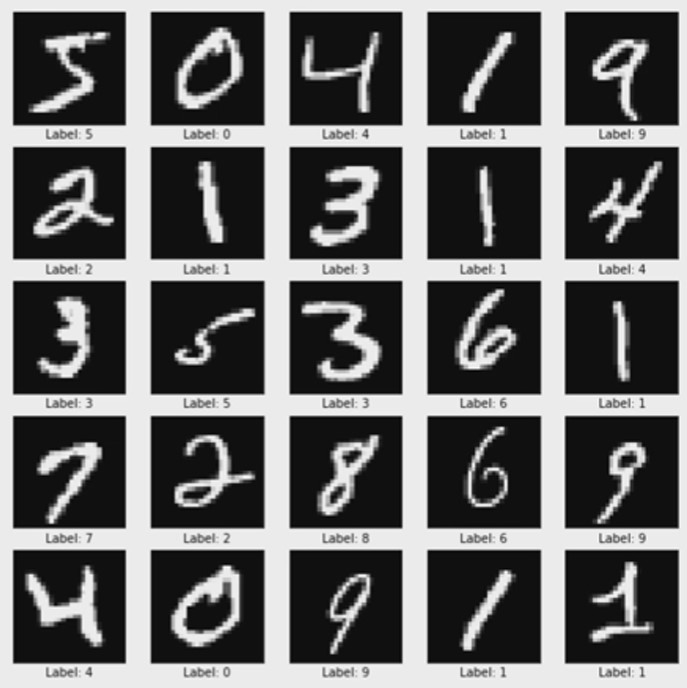

In [1]:
from IPython.display import Image
import os
!ls ../input/
Image("/kaggle/input/rakam-projesi-2-foto/rakamlar.jpg")

Bu 0 ile 9 arasında yer alan rakamalr aslında görsel ögeler ve bunlar 28x28 pixcel boyutlarında. Bu veri setinde yapay sinir ağlarını önce eğitmek için kullanacak olduğumuz 60 bin tane gözlem vardır. 10 bin tane de test seti vardır. Yani toplam 28x28 pixcel 70 bin görüntülü bir veri setimiz var.

## 2) VERİYİ ANLAMAK(DATA UNDERSTANDING)

In [2]:
pip install tensorflow

Note: you may need to restart the kernel to use updated packages.


In [3]:
# Gerekli Kütüphanelerin Import İşlemleri
import tensorflow as tf
from tensorflow.keras.datasets import mnist                   # tf içinden veri setleri
from tensorflow.keras.models import load_model, Sequential    # model kurma
from tensorflow.keras.layers import Dense, Flatten            # Katmanlar
from tensorflow.keras.utils import to_categorical, plot_model # Ön işleme
import matplotlib.pyplot as plt
import numpy as np
import warnings
from warnings import filterwarnings

warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)
filterwarnings('ignore')

In [4]:
# Veri setimizi mnist içinden yüklüyoruz.
(x_train, y_train),(x_test, y_test) = mnist.load_data() # x'ler pixcelleri, y'ler ise çıktıları temsil eder.
# Veri setimizde 10 tane sınıf var(0-9 arası rakamlar). Y bölümleri bu sayıları ifade eder. Bu sayıların 
# karşılığında 28x28'lik pixcellerden oluşan bir görsel var. Onu ifade eden de x_Train bölümü.

11490434/11490434 [==============================] - 1s 0us/step


 60000, 28, 28  -->60 bin görsel var. Bunlar 28x28'lik görseller. 28x28= 784 tane pixcel var burda. Model bu var olan veri
 üzerinden hangi pixcel yoğunlaşmaları hangi sayıya denk geliyor bunu öğrenicek. Daha sonra test setimizle bu öğrenmiş 
 olmanın performansını değerlendiricez.

In [5]:
print("Eğitim seti boyutu: ", x_train.shape, y_train.shape)

Eğitim seti boyutu:  (60000, 28, 28) (60000,)


In [6]:
print("Test seti boyutu: ", x_test.shape, y_test.shape)

Test seti boyutu:  (10000, 28, 28) (10000,)


In [7]:
# Hedef değişkenimizin boyutu 
num_labels = len(np.unique(y_train))   # Hedef değişkenin sınıf sayısı          ###??????????? Nasıl 2 oldu 10 değil mi?
num_labels

10

### Veri Setinden Örnekler Görme

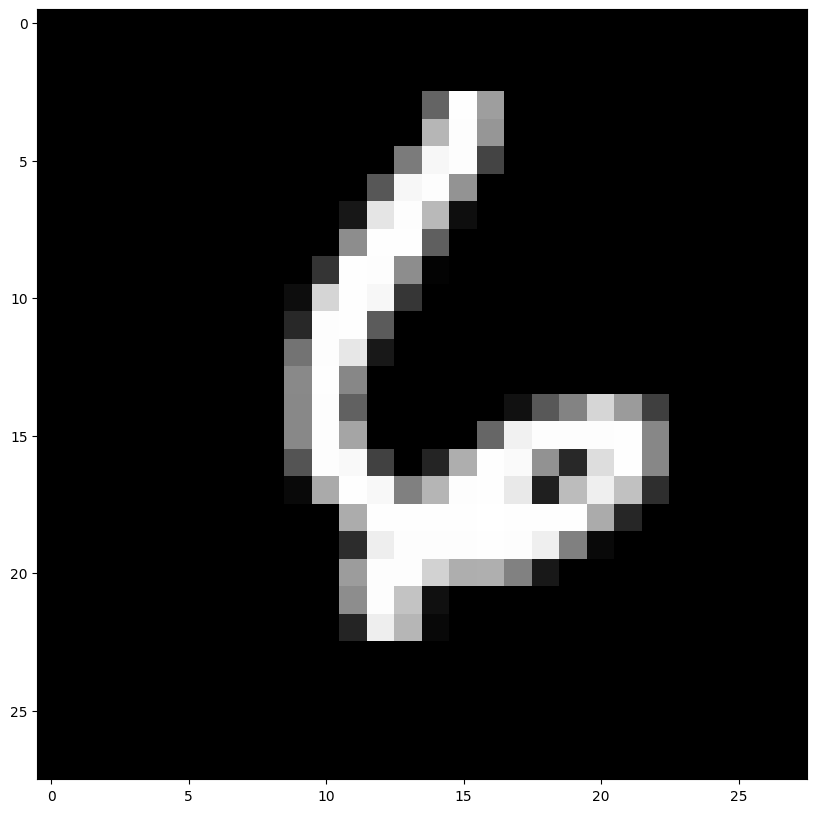

In [8]:
plt.figure(figsize = (10,10)) # Gösterecek olduğumuz görselin 10x10 olmasını istiyoruz. 
# Yani bu notebook'a 10x10 yansıyacak. 
# 60 bin görsel içinden 59 bininciyi görmek istiyoruz.
plt.imshow(x_train[59000], cmap = 'gray')

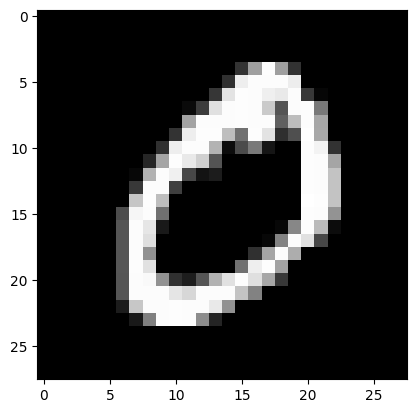

In [9]:
plt.imshow(x_train[1], cmap = 'gray')

Mesela 1 değil 10 tane resim görmek istiyoruz. Resmin boyutları aynı kalsın istediğimiz için figure ayarına dokunmuyoruz. 

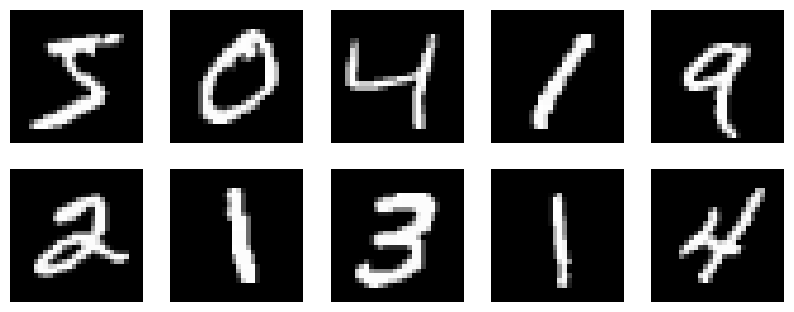

In [10]:
plt.figure(figsize = (10,10))
for n in range(10):
    ax = plt.subplot(5,5,n+1)    # Yazdırırken 5 satır 5 sütun olsun ve bunları alt alta yazdıralım istedik.
    plt.imshow(x_train[n], cmap = 'gray')
    plt.axis("off")              # Eksenleri (x ve y eksenleri) kapatır, böylece görüntüler eksen işaretleri olmadan görüntülenir.

Bu işlemi (yani görselleri görme işlemini) bir fonksiyona döküyoruz.

In [11]:
def visualize_image(data, number = 10):
    plt.figure(figsize=(10, 10))
    for n in range(number):
        ax = plt.subplot(5, 5, n + 1)
        plt.imshow(data[n], cmap='gray')
        plt.axis("off")

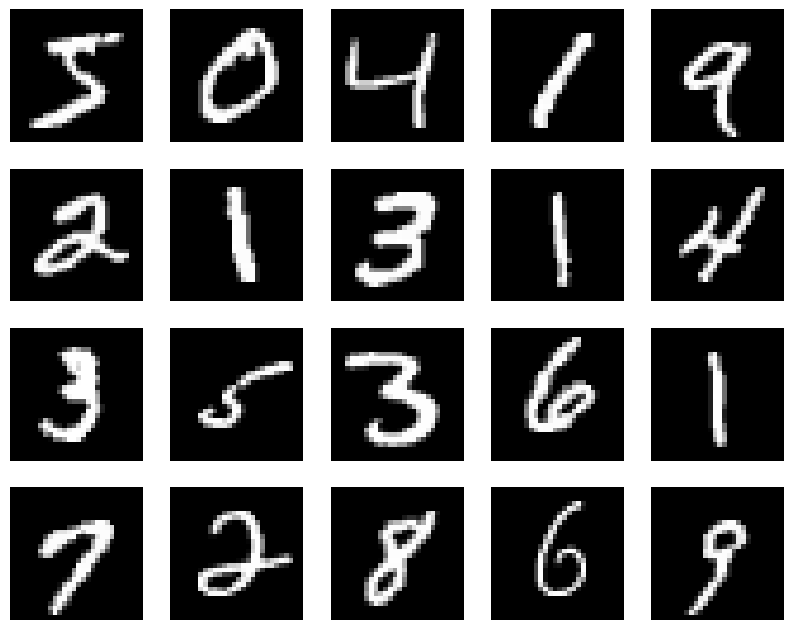

In [12]:
visualize_image(x_train,20)

## 3) VERİYİ SAYISAL TEMSİLLERE DÖNÜŞTÜRMEK

Siyah beyaz renklerden oluşan bir resim sınıflandırma uygulaması yapıyoruz. Bunlar rakamalr. Ve amacımız bu rakamarı bir yapay sinir ağına numerik olarak göndermek. Peki bu resimleri numerik olarak nasıl göndericez?

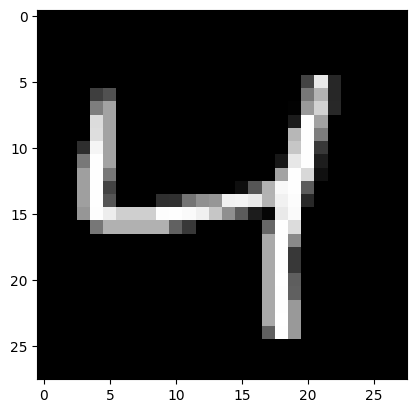

In [13]:
plt.imshow(x_train[2], cmap = 'gray')

Bu görselde toplam 28x28'den 784 tane pixcel var. Kimisi beyaz, kimisi açık gri, koyu gri, siyah vb...

Peki biz bir resim gördüğümüzde bu resimdeki renkleri bilgisayar bize nasıl anlatıyor? Nasıl yansıtıyor? 
- Bilgisayar bize renkleri göstermek için RGB kodları kullanıyor. 

In [14]:
# r:250 g:10 b:240  --> Bu bize moru verir. 
# RGB kodları 0-255 arasında değerler alır. 

RGB CALCULATOR : https://www.w3schools.com/colors/colors_rgb.asp

0 siyahı, 255 beyazı ifade eder. Daha teknik ifadeyle 255 olduğunda en parlak renktir, hepsi 0 olduğunda parlaklık yoktur siyahtır.

Yani bizim bu 784 pixcelden oluşan görselimde herbir pixcelde tek bir sayı var. Bu sayı 0 ise siyah, 255 ise parlak, ikisi arasında değişken ise daha aradaki tonları veriyor olacak.

In [15]:
x_train[2]  # Bir matris formu geldi.

array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,  67, 232,  39,   0,   0,   0,
          0,   0],
       [  

In [16]:
x_train[2].shape

(28, 28)

Mesela şu an istediğimiz noktadaki pixceli istiyoruz. 10. satır ile 10. sütun kesişimindeki pixcel gelsin bize. 

In [17]:
x_train[2][10,10]      # 2 indeksine sahip görseldeki 10. satır ve 10. sütundaki pixcel değeri 0'mış.

0

rakam-projesi-2-foto


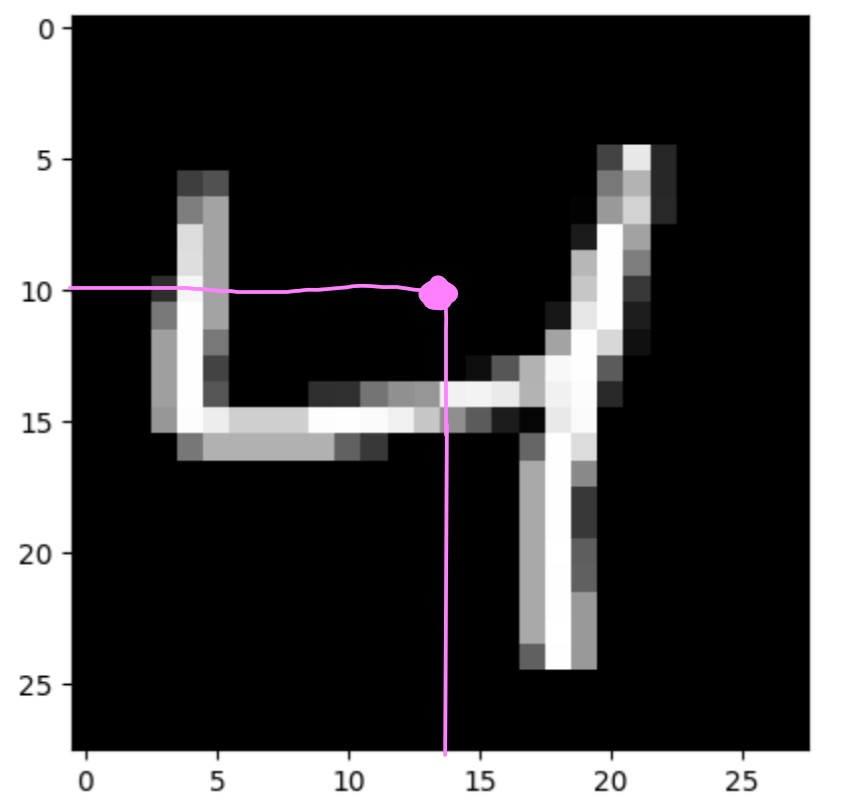

In [18]:
from IPython.display import Image
import os
!ls ../input/
Image("/kaggle/input/rakam-projesi-2-foto/4rkm.jpg")

Şimdi de beyaz olmasını bekleyeceğimiz bir noktaya gidiyoruz. Bunun içinde 14, 10 beyaza denk geliyor gibi.

In [19]:
x_train[2][14,10]  #En azından gri bir bolge

49

Bölgelere gidebildiğimize göre matematiksel işlemlerde yapabiliriz gibi. 

x_train[2]  dediğimizde bu bize bir numpy arreyi getirmişti. O zaman biz bu görserlin ortalamasını alabiliriz.

In [20]:
x_train[2].mean()  #bu resmin numerik temsili 24 olabilir. 

24.799744897959183

In [21]:
x_train[2].sum()  # Pixcellerdeki bütün değerleri topladık. 

19443

In [22]:
# Şimdi de belirli aralıklara gidelim. 14-20, 10-20 arasında
x_train[2][14:20,10:20]

array([[ 49, 116, 144, 150, 241, 243, 234, 179, 241, 252],
       [254, 250, 240, 198, 143,  91,  28,   5, 233, 250],
       [ 98,  56,   0,   0,   0,   0,   0, 102, 254, 220],
       [  0,   0,   0,   0,   0,   0,   0, 169, 254, 137],
       [  0,   0,   0,   0,   0,   0,   0, 169, 254,  57],
       [  0,   0,   0,   0,   0,   0,   0, 169, 254,  57]], dtype=uint8)

Bununda ortalamasını alırsak belirli bir bölgenin ortaqlamasını almış oluruz. Yani aslında resmin farklı bölgelerini zoom yapıyoruz. Yani burdaki bileşenler ayrı ayrı bizim odağımıza girebiliyor. Bu resmi aslında parçalayabiliyoruz. Temelinde bir sinir ağı da bir rakam tanıma, bir el yazısı tanıma bir resim tanıma uygulaması yaptığında aslında yaptığımız gibi resmin içinden numerik temsiller çıkarma çabasına dayanıyor. 

In [23]:
x_train[2][14:20,10:20].mean()

96.51666666666667

Şimdi amacımız bu görseli oluşturan sayıları görselin üzerine koyalım. Bunu bir fonkla yazıcaz. Bu fonk sayesinde elimizdeki herhangi bir resmi veri setimizden seçerek görselleştirebiliriz.

In [24]:
def pixel_visualize(img):
    fig = plt.figure(figsize=(12, 12))
    ax = fig.add_subplot(111)
    ax.imshow(img, cmap='gray')
    width, height = img.shape

    threshold = img.max() / 2.5
    for x in range(width):
        for y in range(height):
            ax.annotate(str(round(img[x][y], 2)), xy=(y, x),
                        color='white' if img[x][y] < threshold else 'black')


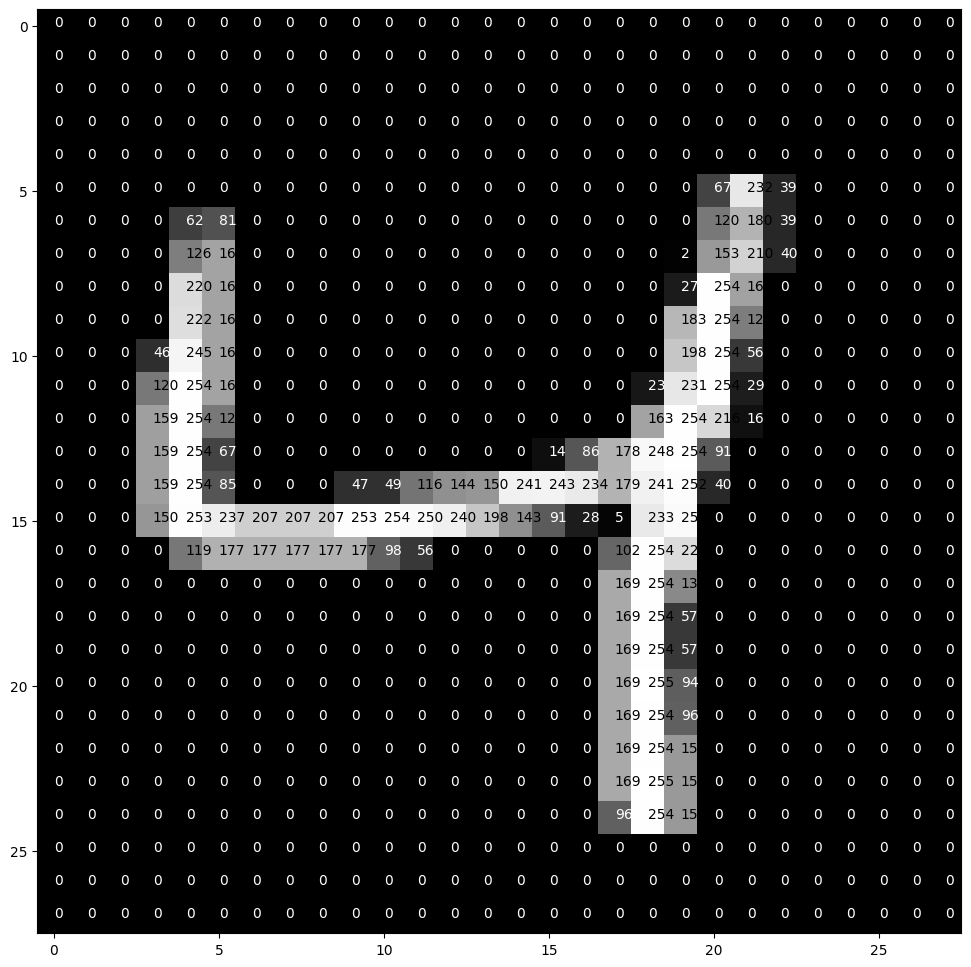

In [25]:
# 2 numaralı resmi görselleştirelim
pixel_visualize(x_train[2])

ÖZET : Göreslleri makine alıyor bu 4 ne 5 ne bunları ayırt edecek yöntemi çıkartmasını öğrenmesini bekliyoruz. Ayırt edicilikleri ifade edecek fonksiyonel yapıyı bul diyoruz. Ve aslında görselleri sayılarla ifade ettiğimizi öğrendik. Biz bunu algoritmaya gönderirken jpg, png dosyasını anlamaz ki bizim ona rakamlar cinsinden bir şeyler ifade etmemiz lazım. Lineer cebir dünyasına girebilmemiz için bunu rakamlarla temsil etmemiz lazım. Burdaki sayıların küçüklüğü büyüklüğü demek burda belirli noktaların parlatılması ya da söndürülmesi demek. 

Yani eğer yöntem bu 4 şeklinin olduğu bu noktalarda bu benzer aydınlatmalara göre bir aydınlatma örüntüsü, yapısı gözlemlerse o zaman yine bir resim geldiğinde onun 4 olduğunu anlayacak.

## 4) VERİYİ HAZIRLAMA(DATA PREPARATION)

Temelinde 3 işlem gerçekleştiricez:
1. Encoding      : (Bağımlı değişken için)
1. Reshaping     : (Elimizdeki veriyi yapay sinir ağlarının kendi yapısal formunda algılayabilmesi için bir yeniden şekillendirme işlemi.
1. Normalization :  (Elimizdeki her bir pixcelde yer alan değerleri belirli bir standarta dönüştürme.)

#### Encoding : 
Labele, outputa, hedef değişkene uygulayacağız.

Önce  [0 1 2 3 4 5 6 7 8 9 ]

Sonra [0 0 1 0 0 0 0 0 0 0 ]

Burada 2 sayısını ifade etmek istediğimizde hedef değişkeni encode etmeden önce 2 diyorduk. Bunu encode ettiğimizde yani binary şekilde 0 1 sisteminde ifade etmek istediğimizde şöyle olmuş olacak. Eğer bir gözlem birimindeki hedef değişkenin değeri 2 ise bunun ona karşılık gelecek noktasına 1 diğerlerine 0 konuluyor.

In [26]:
y_train[0:5]  # array([5, 0, 4, 1, 9] Bunlar bizim sayılarımızı temsil ediyor

array([5, 0, 4, 1, 9], dtype=uint8)

Encoding işlemini hem test hem de train seti için yapmamız gerekiyor.

In [27]:
y_train = to_categorical(y_train) # Burda dönüştürmüş oluyoruz
y_test = to_categorical(y_test) 
# Şu anda değişkenlerin ifade ediliş tarzı one hot encoding tarzıyla gerçekleşmiş oldu. 

In [28]:
y_train[0:5]   # 0. gözle 5 idi. Baktığımızda sadece 5. de 1 var.

array([[0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]], dtype=float32)

#### Reshaping
Amaç pixcelleri boyut olarak aktarabilmek.

In [29]:
image_size= x_train.shape[1]

In [30]:
print(f"x_train boyutu: {x_train.shape}")
print(f"x_test boyutu: {x_test.shape}")

x_train boyutu: (60000, 28, 28)
x_test boyutu: (10000, 28, 28)


Her pixcelde farklı sayılar yazıyor. Bu her pixcelde tutlan sayılarıda boyut olarak tutmamız gerek.

In [31]:
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
x_test= x_test.reshape(x_test.shape[0], 28, 28, 1)
# 1 sayısı görsellerdeki piksellerin değerini tutuyor değerini temsil ediyor.

print(f"x_train boyutu: {x_train.shape}")
print(f"x_test boyutu: {x_test.shape}")
# 2 sayısı 

x_train boyutu: (60000, 28, 28, 1)
x_test boyutu: (10000, 28, 28, 1)


###### Neden 1 yazdık?

Görüntülerin Yapısı: Görüntüler, bir piksel grididir ve her bir pikselin bir değeri vardır. Bu değerler genellikle her bir pikselin rengini veya gri tonlamasını temsil eder. Örneğin, RGB renk modelini kullanan bir renkli bir görüntüde her piksel üç kanal içerir: kırmızı, yeşil ve mavi. Ancak, bazı uygulamalarda gri tonlamalı (siyah-beyaz) görüntülerle çalışılır. Bu tür gri tonlamalı görüntülerde, her piksel sadece bir tek renk tonu taşır.

Kanal Sayısı: Kanal sayısı, bir pikselin kaç farklı özelliği veya kanalı temsil ettiğini belirtir. Gri tonlamalı görüntülerde her piksel yalnızca gri tonlamasını temsil ettiği için kanal sayısı 1 olarak belirtilir. Diğer bir deyişle, her pikselin sadece bir gri tonlama değeri vardır.

CNN ve Görüntü İşleme: Convolutional Neural Networks (CNNs), özellikle görüntü işleme alanında kullanılan derin öğrenme modelleridir. CNN'ler, görüntülerdeki desenleri ve özellikleri tanımak için farklı filtreleri kullanır. Kanallar, bu filtrelerin girdi olarak alacağı verileri temsil eder. Eğer gri tonlamalı görüntülerle çalışıyorsanız, kanal sayısı 1 olur. Eğer renkli bir görüntü ile çalışıyorsanız (RGB), kanal sayısı 3 olur çünkü her piksel üç farklı renk kanalını temsil eder.

Yani, "x_train" ve "x_test" dizilerindeki görüntüleri yeniden şekillendirirken kanal sayısını belirtmek, hangi tür görüntülerle çalıştığınızı ve modelinize hangi tür girdiyi beklediğinizi açıklar. Gri tonlamalı görüntüler için kanal sayısı genellikle 1 olarak ayarlanır. Bu, her pikselin yalnızca bir gri tonlama değeri içerdiği anlamına gelir.

### Normalization/ Standardization

0 ile 255 arasında olan renk değerlerini 0 ile 1 arasında olsun demek istiyoruz. Yani bunların eğitim süresini daha hızlı ya da öğrenme sürecinin daha doğru bir şekilde ya da sonuca daha hızlı gidebileceği bir şekilde gerçekleşmesini sağlamak için standartlaştırmak istiyoruz.

In [32]:
x_train = x_train.astype("float32")/255
x_test = x_test.astype("float32")/255

# 255'e bölerek değerleri 0 ile 1 arasında standartlaştırıyoruz.

Neyi standartlaştırıyoruz?
28 x 28 piksellik görsellerde 784 tane piksel/hücre var. Bu hücrelerde 255'e kadar sayılar var. Bunları standartlaştırıyoruz. Böylece 1'e yakın sayıların daha parlak, 0'a yakın sayıların ise daha koyu olmasını bekleriz.

## 5) MODELING


Her bir göresl 784 pikselden her bir piksel ise 0-255 arasındaki sayılardan oluşuyor.

#### Sinir Ağı Mimarisini Tanımlamak

Verilerimizi hazırladığımıza göre bunu artık yapay sinir ağlarına gönderebiliriz. Ama öncesinde yani modeli eğitmeden önce bu sinir ağının bir mimarisini tanımlamamız gerekiyor. Yani bu kaç katmanlı olacak, kaç tane hücre olacak, çıkış katmanı ne olacak burda kaç tane nöron olacak? gibi noktaları belirlememiz gerekiyor.

Bu işlemi 2 adımda yapacağız iç ve dış özellikler diye. Dışı için örneğin 1 tane katman ekle, 1 çıkış katmanı ekle vs gibi özellikleri belitrmiş olucaz. Diğeri de (iç özellikler) bu sinir ağının matematiksel tarafı. Mesela loss (kayıp fonkumuz ne olacak?), optimizasyon fonkumuz ne olacak (kayıp fonkunu minimize edebilecek olan fonksiyon) gibi kısımlar iç özellikler olarak düşünülebilir.

### 1) Dış Özellikler

In [33]:
model = tf.keras.Sequential([       
    Flatten(input_shape=(28, 28, 1)), 
    Dense(units=128, activation="relu", name="layer1"),   
    Dense(units=num_labels, activation="softmax", name="output_layer")
])

### 1) İç Özellikler

In [34]:
model.compile(loss ='categorical_crossentropy',
              optimizer ='adam',
              metrics =[tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), "accuracy"])

In [35]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 layer1 (Dense)              (None, 128)               100480    
                                                                 
 output_layer (Dense)        (None, 10)                1290      
                                                                 
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
_________________________________________________________________


In [36]:
model.fit(x_train, y_train, epochs=5, batch_size=128, validation_data=(x_test, y_test)) 

Epoch 1/5
469/469 [==============================] - 4s 6ms/step - loss: 0.3617 - precision: 0.9461 - recall: 0.8487 - accuracy: 0.9007 - val_loss: 0.1965 - val_precision: 0.9586 - val_recall: 0.9304 - val_accuracy: 0.9440
Epoch 2/5
469/469 [==============================] - 2s 5ms/step - loss: 0.1658 - precision: 0.9638 - recall: 0.9424 - accuracy: 0.9523 - val_loss: 0.1318 - val_precision: 0.9702 - val_recall: 0.9540 - val_accuracy: 0.9627
Epoch 3/5
469/469 [==============================] - 2s 5ms/step - loss: 0.1179 - precision: 0.9734 - recall: 0.9592 - accuracy: 0.9661 - val_loss: 0.1111 - val_precision: 0.9738 - val_recall: 0.9613 - val_accuracy: 0.9668
Epoch 4/5
469/469 [==============================] - 3s 5ms/step - loss: 0.0930 - precision: 0.9789 - recall: 0.9688 - accuracy: 0.9735 - val_loss: 0.0986 - val_precision: 0.9770 - val_recall: 0.9660 - val_accuracy: 0.9700
Epoch 5/5
469/469 [==============================] - 2s 5ms/step - loss: 0.0746 - precision: 0.9827 - recall

## 6) Model Başarı Değerlendirme(Evaluation)

In [37]:
history = model.fit(x_train, y_train, epochs=5, batch_size=128, validation_data=(x_test, y_test))

Epoch 1/5
469/469 [==============================] - 3s 5ms/step - loss: 0.0619 - precision: 0.9852 - recall: 0.9788 - accuracy: 0.9819 - val_loss: 0.0838 - val_precision: 0.9791 - val_recall: 0.9724 - val_accuracy: 0.9750
Epoch 2/5
469/469 [==============================] - 2s 5ms/step - loss: 0.0532 - precision: 0.9873 - recall: 0.9821 - accuracy: 0.9847 - val_loss: 0.0804 - val_precision: 0.9791 - val_recall: 0.9730 - val_accuracy: 0.9759
Epoch 3/5
469/469 [==============================] - 2s 5ms/step - loss: 0.0446 - precision: 0.9895 - recall: 0.9852 - accuracy: 0.9873 - val_loss: 0.0736 - val_precision: 0.9803 - val_recall: 0.9757 - val_accuracy: 0.9773
Epoch 4/5
469/469 [==============================] - 2s 5ms/step - loss: 0.0379 - precision: 0.9910 - recall: 0.9875 - accuracy: 0.9890 - val_loss: 0.0776 - val_precision: 0.9805 - val_recall: 0.9740 - val_accuracy: 0.9765
Epoch 5/5
469/469 [==============================] - 2s 5ms/step - loss: 0.0323 - precision: 0.9929 - recall

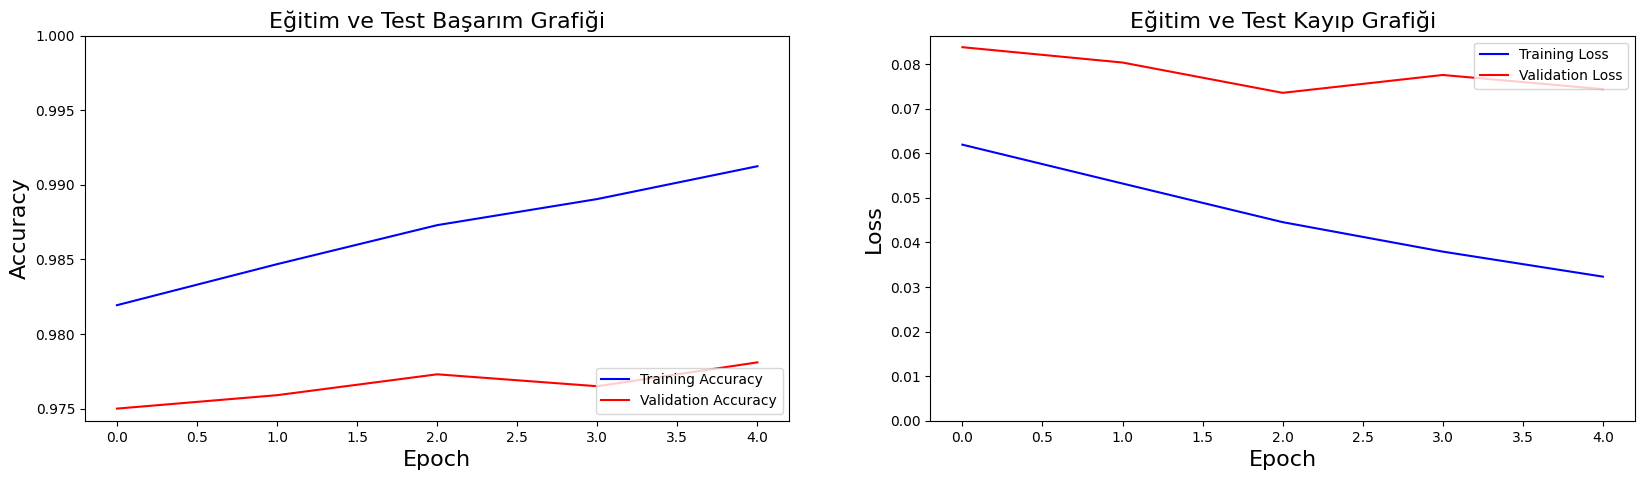

In [38]:
#############################
# Accuracy ve Loss Grafikleri
#############################
# Grafik 1 Accuracy
plt.figure(figsize=(20, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], color='b', label='Training Accuracy')
plt.plot(history.history['val_accuracy'], color='r', label='Validation Accuracy')
plt.legend (loc='lower right')
plt.xlabel('Epoch', fontsize=16)
plt.ylabel('Accuracy', fontsize=16)
plt.ylim([min(plt.ylim()),1])
plt.title('Eğitim ve Test Başarım Grafiği', fontsize=16)

# Grafik 2 Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], color='b', label='Training Loss')
plt.plot(history.history['val_loss'], color='r', label='Validation Loss')
plt.legend (loc='upper right')
plt.xlabel('Epoch', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.ylim([0,max(plt.ylim())])
plt.title('Eğitim ve Test Kayıp Grafiği', fontsize=16)
plt.show()


In [39]:
loss, precision, recall, acc = model.evaluate(x_test, y_test, verbose=False)
print("\nTest Accuracy: %.1f%%" % (100.0 * acc))
print("\nTest Loss: %.1f%%" % (100.0 * loss))
print("\nTest Precision: %.1f%%" % (100.0 * precision))
print("\nTest Recall: %.1f%%" % (100.0 * recall))


Test Accuracy: 97.8%

Test Loss: 7.4%

Test Precision: 98.1%

Test Recall: 97.6%


## 7) MODELİN KAYDEDİLMESİ VE TAHMİN İÇİN KULLANILMASI

In [40]:
model.save("mnist_model.h5")   # h5 bir dosya formatı.

In [41]:
import random
random = random.randint(0, x_test.shape[0])
random

8335

In [42]:
test_image = x_test[random] 
y_test[random]

array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

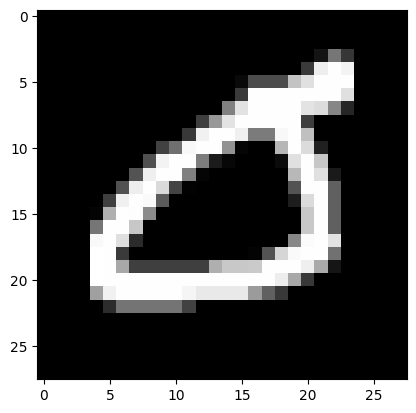

In [43]:
plt.imshow(test_image.reshape(28,28), cmap = "gray")

In [44]:
test_data = x_test[random].reshape(1,28,28,1)

In [45]:
probability = model.predict(test_data)

1/1 [==============================] - 0s 112ms/step


In [46]:
probability

array([[9.9972504e-01, 2.8161799e-07, 1.8929553e-04, 9.3680370e-07,
        1.3556586e-06, 5.1820103e-07, 7.7769677e-05, 2.8679103e-06,
        1.3303902e-08, 1.8990179e-06]], dtype=float32)

In [47]:
predicted_classes = np.argmax(probability)
predicted_classes 

0

In [48]:
print(f"Tahmin Edilen Sınıf: {predicted_classes} \n")
print(f"Tahmin Edilen Sınıfın Olasılık Değeri: {(np.max(probability, axis=-1))[0]} \n")
print(f"Diğer Sınıfların Olasılık Değerleri: \n{probability}")

Tahmin Edilen Sınıf: 0 

Tahmin Edilen Sınıfın Olasılık Değeri: 0.9997250437736511 

Diğer Sınıfların Olasılık Değerleri: 
[[9.9972504e-01 2.8161799e-07 1.8929553e-04 9.3680370e-07 1.3556586e-06
  5.1820103e-07 7.7769677e-05 2.8679103e-06 1.3303902e-08 1.8990179e-06]]
